<a href="https://colab.research.google.com/github/Asegorova26/Kursovaya/blob/main/%D0%9A%D1%83%D1%80%D1%81%D0%BE%D0%B2%D0%B0%D1%8F_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0_%D0%95%D0%B3%D0%BE%D1%80%D0%BE%D0%B2%D0%B0%D0%90%D0%A1_%D0%91%D0%98%D0%92%D0%A2_20_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Курсовая работа

ФИО: Егорова Анастасия Станиславовна
Группа: БИВТ-20-2

###Импорт необходимых библиотек и загрузка датасета

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, models, transforms
import time
import os
import copy

In [ ]:
!pip install datasets

In [ ]:
from datasets import load_dataset

dataset = load_dataset("AI-Lab-Makerere/beans")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/1034 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/133 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/128 [00:00<?, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 1034
    })
    validation: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 133
    })
    test: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 128
    })
})

# 2. Создание и описание датасета, маркировка изображений

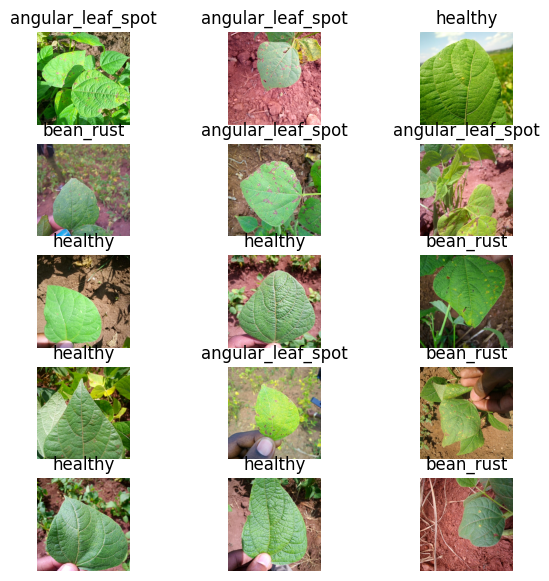

In [ ]:
# Сопоставление меток классов с числовыми идентификаторами
map_of_labels = {0:'angular_leaf_spot', 1: 'bean_rust', 2: 'healthy' }
figure = plt.figure(figsize=(7, 7))
cols, rows = 3, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(dataset['train']['image']), size=(1,)).item()
    img, label = dataset['train'][sample_idx]['image'], dataset['train'][sample_idx]['labels']
    figure.add_subplot(rows, cols, i)
    plt.title(map_of_labels[label])
    plt.axis("off")
    plt.imshow(img)
plt.show()

# 3. Преобразование датасета

In [ ]:
train_dataset =dataset['train']
test_dataset = dataset['test']

In [ ]:
class NewDataset(Dataset):
  def __init__(self, data, transforms):
      self.data = data
      self.transform = transforms

  def __len__(self):
      return len(self.data)

  def __getitem__(self, idx):
      images = self.data[idx]['image'].convert('RGB')
      images = self.transform(images)
      labels = self.data[idx]['labels']

      return images, labels

In [ ]:
apply_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((716, 375)),
        transforms.RandomHorizontalFlip(0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
    ]),
    'validation':
    transforms.Compose([
        transforms.Resize((716, 375)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
    ]),
    'test':
    transforms.Compose([
        transforms.Resize((716, 375)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
    ])
}

In [ ]:
dataset_train = NewDataset(dataset['train'], apply_transforms['train'])
dataset_val = NewDataset(dataset['validation'], apply_transforms['validation'])
dataset_test = NewDataset(dataset['test'], apply_transforms['test'])

In [ ]:
dataset = {'train': dataset_train, 'val': dataset_val, 'test': dataset_test}

# 5. Создание архитектуры нейросети и ее тренировка на подготовленном датасете

Создаем даталоудеры для трейн и тест наборов

In [ ]:
dataloader_train = DataLoader(dataset['train'], batch_size=16, shuffle=True, num_workers=0)
dataloader_val = DataLoader(dataset['val'], batch_size=16, shuffle=True, num_workers=0)
dataloader_test = DataLoader(dataset['test'], batch_size=16, shuffle=False, num_workers=0)

In [ ]:
dataloaders = {'train': dataloader_train, 'val': dataloader_val,'test': dataloader_test}

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


Функция обучения нейросети

In [ ]:
def train_model(model, dataloader, criterion, optimizer, scheduler, epochs=18):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch+1, epochs))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(dataset[phase])
            epoch_acc = running_corrects.double() / len(dataset[phase])

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

In [ ]:
# Получаем батч обучающих данных
inputs, classes = next(iter(dataloaders['train']))

Создание модели нейросети

In [ ]:
model = nn.Sequential(
    nn.Conv2d(3, 16, 3, 2),
    nn.BatchNorm2d(16),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, stride=1),
    nn.Conv2d(16, 32, 3, 2, 1),
    nn.BatchNorm2d(32),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(3, stride=2),
    nn.Conv2d(32, 128, 5, 2, 1),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(3, stride=2),
    nn.Conv2d(128, 128, 3, 2, 1),
    nn.Flatten(),
    nn.Linear(7040, 1024),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(1024, 256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, 3)
)


out = model(inputs)
print(out.shape)
model = model.to(device)

torch.Size([16, 3])


In [ ]:
criterion = nn.CrossEntropyLoss()
adam_optimizer = optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-5)
scheduler = lr_scheduler.StepLR(adam_optimizer, step_size=5, gamma=0.1)

Запустим обучение нашей сети

In [ ]:
model = train_model(model, dataloaders, criterion, adam_optimizer, scheduler, epochs=10)

Epoch 1/10
----------
train Loss: 0.8088 Acc: 0.6412
val Loss: 0.6428 Acc: 0.7068

Epoch 2/10
----------
train Loss: 0.6555 Acc: 0.7186
val Loss: 0.5500 Acc: 0.7669

Epoch 3/10
----------
train Loss: 0.5862 Acc: 0.7456
val Loss: 0.4176 Acc: 0.8421

Epoch 4/10
----------
train Loss: 0.5050 Acc: 0.7814
val Loss: 0.4841 Acc: 0.7820

Epoch 5/10
----------
train Loss: 0.4873 Acc: 0.7921
val Loss: 0.3581 Acc: 0.8571

Epoch 6/10
----------
train Loss: 0.3209 Acc: 0.8607
val Loss: 0.3204 Acc: 0.8722

Epoch 7/10
----------
train Loss: 0.2925 Acc: 0.8830
val Loss: 0.3032 Acc: 0.8647

Epoch 8/10
----------
train Loss: 0.2622 Acc: 0.8975
val Loss: 0.2985 Acc: 0.8722

Epoch 9/10
----------
train Loss: 0.2502 Acc: 0.9004
val Loss: 0.2903 Acc: 0.8722

Epoch 10/10
----------
train Loss: 0.2311 Acc: 0.9091
val Loss: 0.2871 Acc: 0.8872

Training complete in 3m 36s
Best val Acc: 0.887218


#Функции для определения метрик.

In [ ]:
def all_accuracy(net, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.cuda(), labels.cuda()
            outputs = net(images)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 582 test images: {} %'.format(
        100 * correct / total))

In [ ]:
def class_accuracy(net, testloader):
    class_correct = list(0. for i in range(11))
    class_total = list(0. for i in range(11))
    with torch.no_grad():
        for data in testloader:
            images, all_labels = data
            images, all_labels = images.cuda(), all_labels.cuda()
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == all_labels).squeeze()
            for i in range(len(all_labels)):
                label = all_labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1


    for i in range(11):
        if class_total[i] != 0:
          print('Accuracy of {} : {} %'.format(
              i, 100 * class_correct[i] / class_total[i]))

#Выводы

In [ ]:
all_accuracy(model, dataloaders['test'])

class_accuracy(model, dataloaders['test'])

Accuracy of the network on the 582 test images: 89.84375 %
Accuracy of 0 : 86.04651162790698 %
Accuracy of 1 : 90.69767441860465 %
Accuracy of 2 : 92.85714285714286 %
